## Supplementary Figure 7, Supplementary Table 6 - Mutations

This notebook covers the genomic promoter analysis for non-cnsensus sites and mutations. Since genomic data (ie. the human genome, promoter regions) are being use there is some initial setup required. This notebook also relies on some external tools (BEDTools, MEME Suite). 


### Dependencies 

These need to be installed beforehand and added to PATH. 

1. BEDtools
2. MEME Suite
    - FIMO
    - uniprobe2meme
    - fasta-get-markov

### Genomic Init Folder setup

The skcm_mutations.bed file needs to be placed in the GENOMIC_DIR folder indicated in the next code block. The methodology for downloading and preparing the data for analysis is described in the Supplementary Materials section of the paper: Analysis of non-consensus sites in human promoters. The format the file is in should resemble the following at the start of the analysis:

| Chromosome | SNP Location (1-base) | SNP Location (1-base) | Original | Variant |

This is later converted into a 0-base inclusive-exclusive format for trimers and SNPs. 

A copy of the hg19 human genome in fasta format is also required and needs to be specified with the HUMAN_GENOME variable. The UCSC hg19 upstream2000.fa and hg19.chrom.sizes files also need to be placed in that directory.


#### Imports and Global Variables

In [1]:
from collections import defaultdict
import glob
import itertools
import os
import subprocess

from Bio import SeqIO
from Bio.Seq import reverse_complement
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

#######################
# IO Global Variables #
#######################

# Main output folder
OUTPUT_DIR = "../Figure_S7"
# Table output
OUTPUT_TABLE_DIR = "../Table_S6"
GENOMIC_INIT_DIR = f"../Genomic_Analysis_Files"
# Location of UV preferred 6-mers
KMER_6MER_DIR = "../../Design/Concatinated_Kmers_Design/Data/"
CREB1_6MER_FILE = f"{KMER_6MER_DIR}/CREB1_0_1/OLS_CREB1_0_1_Escore.txt"
EGR1_6MER_FILE = f"{KMER_6MER_DIR}/EGR1_2_3/OLS_EGR1_2_3_Escore.txt"
# Location of USCS promoter fasta file
UCSC_PROMOTER_FASTA_FILE = f"{GENOMIC_INIT_DIR}/upstream2000.fa"
HUMAN_GENOME_FILE = f"{GENOMIC_INIT_DIR}/human_g1k_v37.fasta"
# Location of PWM to use in site calling
PWMS_TABLE_S3A = "../Table_S3/Table_S3A_PWM_Probabilities.csv"
# Output locations
PROMOTER_3MERS_DIR = f"{OUTPUT_DIR}/Promoter_3mers"
BACKGROUND_INTERSECTION_DIR = f"{OUTPUT_DIR}/Background_Intersection"
PROMOTER_MUTATIONS_DIR_HS = f"{OUTPUT_DIR}/Promoter_Mutations_HS"
ANNOTATED_PROMOTER_MUTATIONS_DIR = f"{OUTPUT_DIR}/Promoter_Mutations_Annotated_HS"
SHUFFLED_SITES_DIR = f"{OUTPUT_DIR}/Shuffled_Sites_Within_Promoter"
SHUFFLED_SITE_BACKGROUND_DIR = f"{OUTPUT_DIR}/Shuffled_Site_Backgrounds"
SHUFFLED_INTERSECTIONS_DIR = f"{OUTPUT_DIR}/Shuffled_Site_Backgrounds_Intersection"

################################
# Intermediate files generated #
################################

# Bed file of 2kb promoters
promoter_bed_file = f"{OUTPUT_DIR}/Promoter2000.bed"
# Sorted version of the promoter bed file
promoter_sorted_bed_file = f"{OUTPUT_DIR}/Promoter2000_Sorted.bed"
# Promoter regions with no overlaps
promoter_merged_bed_file = f"{OUTPUT_DIR}/Promoter2000_Merged.bed"
# Mutations within the promoter (1bp)
skcm_promoter_mutations_file = f"{OUTPUT_DIR}/skcm_mutations_promoter2000.bed"
# Mutations within the promoter in a trimer context
skcm_promoter_mutations_trimer_bed_file = f"{OUTPUT_DIR}/skcm_mutations_promoter2000_trimer.bed"
# TSV file of the sequences
skcm_mutations_trimer_sequence_tsv_file = f"{OUTPUT_DIR}/skcm_mutations_promoter2000_trimer_sequences.tsv"
# Same as skcm_promoter_mutations_file but the 4th column is the sequence
skcm_mutations_trimer_sequence_bed_file = f"{OUTPUT_DIR}/skcm_mutations_promoter2000_trimer_sequences.bed"
promoter_fasta_file = f"{OUTPUT_DIR}/Promoter2000.fasta"
promoter_fasta_merged_file = f"{OUTPUT_DIR}/Promoter2000_Merged.fasta"
promoter_trimer_counts_txt_file = f"{OUTPUT_DIR}/Promoter_Trimer_Counts.txt"
creb1_pwm_promoter_calls_unique_file = f"{OUTPUT_DIR}/CREB1_PWM_promoter_calls_unique.bed"
egr1_pwm_promoter_calls_unique_file = f"{OUTPUT_DIR}/EGR1_PWM_promoter_calls_unique.bed"

##############################
# Parameter Global Variables #
##############################

# Tuple of non-consensus k-mer runs lengths to analyze
NC_LENGTH_TUP = (20, 25, 30)
# Tuple of transcription factors to analyze
TF_TUP = ("CREB1", "EGR1")

In [3]:
# Create output folders if not already present
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_TABLE_DIR, exist_ok=True)
os.makedirs(PROMOTER_3MERS_DIR, exist_ok=True)
os.makedirs(PROMOTER_MUTATIONS_DIR_HS, exist_ok=True)
os.makedirs(ANNOTATED_PROMOTER_MUTATIONS_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/Promoter_Backgrounds_HS", exist_ok=True)
os.makedirs(SHUFFLED_SITES_DIR, exist_ok=True)
os.makedirs(SHUFFLED_SITE_BACKGROUND_DIR, exist_ok=True)
os.makedirs(SHUFFLED_INTERSECTIONS_DIR, exist_ok=True)


## Process the UCSC FASTA Promoter File

**These are placed in Figure_S7 DIR**

The promoter fasta file has the sequences relative to the strand of the gene. For this analysis, having all sequences on the plus strand simplifies the process. Using the FASTA labels, a BED file is generates from the promoter FASTA file.

**File Output:**

1. **Promoter2000.bed** - Bed coordinates of upstream2000.fa from USCS
2. **Promoter2000_Sorted.bed** - Sorted version of Promoter2000.bed 
3. **Promoter2000_Merged.bed** - Merged version of Promoter2000_Sorted.bed 
4. **Promoter2000.fasta** - Fasta file from Promoter2000.bed
5. **Promoter2000_Merged.fasta** - Fasta file from Promoter2000_Merged.bed 

In [4]:
bed = []
# Read promoter file and parse genomic coordinates
with open(UCSC_PROMOTER_FASTA_FILE) as file_obj:
    for record in SeqIO.parse(file_obj, "fasta"):
        genomic_coords = record.description.split()[1].strip()
        if not any([i in genomic_coords for i in ["alt", "fix", "random", "chrUn", "hap"]]):
            chrom = genomic_coords.split(":")[0]
            start = int(genomic_coords.split(":")[1].split("-")[0]) - 1
            end = genomic_coords.split(":")[1].split("-")[1]
            bed.append((chrom, start, end))
beddf = pd.DataFrame(bed)
beddf = beddf.rename(columns={0:"Chr", 1:"Start", 2:"End"})
beddf = beddf.drop_duplicates().reset_index(drop=True)
beddf.to_csv(promoter_bed_file, sep="\t", header=None, index=False)

In [5]:
%%bash -s "$promoter_bed_file" "$promoter_sorted_bed_file" "$promoter_merged_bed_file"
# Sort and merge the promoter file to create a merged promoter file with no overlaps
bedtools sort -i $1 > $2
bedtools merge -i $2 > $3

In [6]:
%%bash -s "$HUMAN_GENOME_FILE" "$promoter_bed_file" "$promoter_fasta_file" "$promoter_merged_bed_file" "$promoter_fasta_merged_file"
# Run bedtools getfasta to convert the non-merged and merged promoters to fasta
bedtools getfasta -fi $1 -bed $2 -fo $3
bedtools getfasta -fi $1 -bed $4 -fo $5

### Background models of promoter sequence

A background model for use in FIMO was generated from the promoter_merged_fasta file and saved to GENOMIC_DIR with the following command:

```bash
fasta-get-markov Promoter2000_Merged.fasta > Promoter2000_Merged_markov_bkg.txt
```

A copy of this file is saved in the Genomic_Analysis_Files folder. 

## Functions

This block is for all functions used in the analysis. 

In [7]:
def uv_preferred_kmer_set(kmer_file):
    kmers = pd.read_csv(kmer_file, sep='\t', skiprows=7)
    uvpref = kmers[kmers["Escore_UV9"] > kmers["Prediction_Interval_Upper"]].reset_index(drop=True)
    uvpkmers = set(list(uvpref["kmerFwd"]) + list(uvpref["kmerRC"]))
    return uvpkmers

def count_kmers_sepstrd(sequence, to_dict, k=3):
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        if "N" not in kmer:
            to_dict[kmer] += 1

def count_kmers(sequence, to_dict, k=6):
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        if "N" not in kmer:
            if kmer in to_dict:
                to_dict[kmer] += 1
            else:
                to_dict[reverse_complement(kmer)] += 1
            
def count_chromosome_kmers(chromosome_file, to_dict, k=6):
    prefix_idx = -1 * (k-1)
    with open(chromosome_file) as file_obj:
        next(file_obj) # Skip header
        prefix = "" # Previous sequence that overlaps with the next
        for i in file_obj:
            line = prefix + i.strip().upper()
            count_kmers(line, to_dict)
            prefix = line[prefix_idx:]
            
def count_chromosome_kmers_pipeline(input_file, output_file, k=6):
    result_dict = defaultdict(int)
    count_chromosome_kmers(input_file, result_dict, k)
    result_df = pd.DataFrame.from_dict(result_dict,
                             orient='index').reset_index()
    result_df = result_df.rename(columns={"index":"Kmer", 0:"Count"})
    result_df.to_csv(output_file, index=False)
    
    
def get_match_idxs(string, kmers, k=6):
    """Get indexes of k-mer matches to a string.
    
    Given a string and set of k-mers, return a list of start
    indexes for matches.
    """
    string = string.upper()
    matches = []
    for idx in range(len(string) - k + 1):
        if string[idx:idx+k] in kmers:
            matches.append(idx)
    return matches


def ranges_from_match_idxs(matches, k=6): # Gets range of first, should not start again for already considered.
    """Given a list of match indexes, return a list of range tuples.
    
    Converts a list of match indexes into a list of tuples where each
    tuple indicates the start (inclusive) and end (exclusive) of consecutuve matches.
    """
    if len(matches) == 0:
        return []
    elif len(matches) == 1:
        return [(matches[0], matches[0] + k)]
    regions = []
    start = matches[0]
    last_seen = start
    for i in matches[1:]:
        if last_seen + 1 != i:
            # Save last result
            regions.append((start, last_seen + 1 + k))
            # Make new range
            start = i
        last_seen = i
    if regions[-1][0] != start:
        regions.append((start, last_seen + 1 + k))
    return regions


def ranges_to_bed(range_list, chromosome, start, name):
    bed_coordinates = []
    for i in range_list:
        bed_coordinates.append((chromosome, start + i[0], start + i[1], name))
    return bed_coordinates


def name_from_label(label):
    r = label.split("_")
    return "_".join(r[:2] + r[5:])


def max_length_from_range_list(range_list):
    if len(range_list) == 0:
        return 0
    length_list = list(map(lambda x: x[1] - x[0], range_list))
    return max(length_list)
    

def call_nonconsensus_sites(string, kmers, k=6):
    matches = get_match_idxs(string, kmers, k)
    ranges = ranges_from_match_idxs(matches)
    #filtered_ranges = list(filter(lambda x: x[1] - x[0] >= min_size, ranges))
    return ranges

def call_sites_from_fasta(fasta_file, kmers):
    sites = []
    with open(fasta_file) as file_obj:
        for record in SeqIO.parse(file_obj, "fasta"):
            site_ranges = call_nonconsensus_sites(str(record.seq), kmers)
            genomic_coords = record.description
            chromosome = genomic_coords.split(":")[0]
            start = int(genomic_coords.split(":")[1].split("-")[0])
            name = name_from_label(record.id)
            sites = sites + ranges_to_bed(site_ranges, chromosome, start, name)
    sites_df = pd.DataFrame(sites)
    return sites_df

def call_sites_pipeline(fasta_file,
                        kmer_dict,
                        tf,
                        output_name):
    sites = call_sites_from_fasta(fasta_file, kmer_dict[tf])
    sites = sites.rename(columns={0: "Chromosome", 1: "Start", 2: "End", 3: "Name"})
    output_file = f"{OUTPUT_DIR}/{output_name}"
    sites.to_csv(output_file, sep='\t', header=None, index=False)
    
def longest_ncsites_from_calls(nc_call_file, tf):
    promoter_ncsite_dict = defaultdict(int)
    with open(nc_call_file) as file_obj:
        for i in file_obj:
            c, s, e, promoter = i.strip().split()
            site_len = int(e) - int(s)
            if site_len > promoter_ncsite_dict[promoter]:
                promoter_ncsite_dict[promoter] = site_len
    site_df = pd.DataFrame.from_dict(promoter_ncsite_dict, orient='index')
    site_df = site_df.reset_index().rename(columns={"index":"Promoter", 0:f"Longest_{tf}_NCSite"})
    return site_df


def unique_calls_bedfmt_from_fimo(fimo_file, output):
    df = pd.read_csv(fimo_file, sep='\t')
    df = df[["sequence_name", "start", "stop"]].drop_duplicates()
    df.to_csv(output,
              sep='\t',
              header=None,
              index=False)
    
def genomic_coord_list_from_bed(bed_file):
    genomic_coord_list = []
    with open(bed_file) as read_obj:
        for line in read_obj:
            chrom, start, end = line.strip().split()
            genomic_coord_list.append(f"{chrom}:{start}-{end}")
    return genomic_coord_list


def add_kmer_positions(string, k, label, to_dict):
    """Get indexes of k-mer matches to a string.
    
    Given a string and set of k-mers, return a list of start
    indexes for matches.
    """
    string = string.upper()
    for idx in range(len(string) - k + 1):
        kmer = string[idx:idx+k] 
        to_dict[kmer].append((label, idx))
    
def mutation_rate_from_file(mutation_count_file):
    total_len = 0
    mutation_count = 0
    with open(mutation_count_file) as read_obj:
        for line in read_obj:
            chrom, start, end, count = line.strip().split('\t')
            site_len = int(end) - int(start)
            total_len += site_len
            mutation_count += int(count)
    return mutation_count / total_len


def measured_mutation_rate_df(tf_tuple=TF_TUP,
                              measured_mutation_folder=OUTPUT_DIR,
                              suffix=''):
    mutation_df = []
    for tf in tf_tuple:
        for min_length in NC_LENGTH_TUP:
            mr = mutation_rate(f"{measured_mutation_folder}/NonConsensus_{tf}_in_Promoters_{min_length}_Unique_Mutation_Counts{suffix}.bed")
            mutation_df.append((f"{tf}_{min_length}", mr))
        mr = mutation_rate(f"{measured_mutation_folder}/{tf}_PWM_Promoter_Unique_Mutation_Counts{suffix}.bed")
        mutation_df.append((f"{tf}_pwm", mr))
    mutation_df = pd.DataFrame(mutation_df).rename(columns={0:"variable", 1:"value"})    
    return mutation_df

def plot_mutation_rate(background_mr_df, measured_mr_df):
    sns.stripplot(data=background_mr_df, x="variable", y="value", size=3, color='black')
    sns.stripplot(data=measured_mr_df, x="variable", y="value", size=6, color='red')
    plt.xticks(rotation=90)
    plt.xlabel(xlabel='')
    plt.ylabel(ylabel='Mutation Rate (sum mutations / total length)')
    
    
def to_zscore(x, mean, std):
    return (x - mean) / std

def p_value_of_mutation(backgrounds, mutation_value, label):
    # Create a list of all data, with the mutation value at the end
    mean = np.mean(backgrounds)
    std = np.std(backgrounds)
    mutation_zscore = to_zscore(mutation_value, mean, std)
    return (label, mean, std, mutation_value, mutation_zscore, scipy.stats.norm.sf(abs(mutation_zscore))*2)

def p_values_of_mutations(background_df, mutation_df):
    results = []
    groups = sorted(list(set(background_df["variable"])))
    for i in groups:
        backgrounds = background_df[background_df["variable"] == i]["value"]
        mutation_value = float(mutation_df[mutation_df["variable"] == i]["value"])
        pvalue_results = p_value_of_mutation(backgrounds, mutation_value, i)
        results.append(pvalue_results)
    return pd.DataFrame(results).rename(columns={0:"Group",
                                                 1:"Bkg_Mean",
                                                 2:"Bkg_Std",
                                                 3:"Fg_Value",
                                                 4:"Fg_Zscore",
                                                 5:"P_Value"})

## Calling Binding Sites

#### (1) Call Non-Consensus Sites in the Promoter


**Output files:**

OUTPUT_DIR
1. **NonConsensus_{tf}_promoter_calls.bed** - non-consensus site calls at any length
2. **NonConsensus_{tf}_promoter_calls_\{min_length}.bed** - non-consensus site calls at least {min_length} long
3. **NonConsensus_{tf}_in_Promoters_\{min_length}_unique.bed** - unique non-consensus site calls at least {min_length} long

In [8]:
# Read UV_Preferred K-mers and organize as a dictionary of sets
kmer_dict_files = (("CREB1",CREB1_6MER_FILE ),
                   ("EGR1", EGR1_6MER_FILE ))
# From input files, return a dictionary where the key is the TF and value is a set of UV-preferred kmers
kmer_dict = {}
for tf, file in kmer_dict_files:
    pref_kmers = uv_preferred_kmer_set(file)
    kmer_dict[tf] = pref_kmers

In [9]:
for tf in TF_TUP:
    print(f"Calling Non-Consensus sites for {tf}...")
    # Create non-consensus site calls at any length
    call_sites_pipeline(promoter_fasta_file,
                        kmer_dict,
                        tf,
                        f"NonConsensus_{tf}_promoter_calls.bed")
    for min_length in NC_LENGTH_TUP:
        # Create BED file with minimum k-mer runs
        with open(f"{OUTPUT_DIR}/NonConsensus_{tf}_promoter_calls.bed") as read_obj, \
             open(f"{OUTPUT_DIR}/NonConsensus_{tf}_promoter_calls_{min_length}.bed", 'w') as write_obj:
            for line in read_obj:
                chrom, start, end, name = line.strip().split()
                site_len = int(end) - int(start)
                if site_len >= min_length:
                    write_obj.write(f"{chrom}\t{start}\t{end}\n")
        # Create a BED file with unique sites
        df = pd.read_csv(f"{OUTPUT_DIR}/NonConsensus_{tf}_promoter_calls_{min_length}.bed",
                         sep='\t',
                         header=None)
        df = df.drop_duplicates().reset_index(drop=True)
        df.to_csv(f"{OUTPUT_DIR}/NonConsensus_{tf}_promoter_calls_{min_length}_unique.bed",
                  sep='\t',
                  header=None,
                  index=False)

Calling Non-Consensus sites for CREB1...
Calling Non-Consensus sites for EGR1...


#### (2) Call Canonical Sites in the Promoter

Call sites using the Non-UV PWMs for CREB1 and EGR1 to use as a comparison for the non-consensus sites.

**Output files:**

OUTPUT_DIR
1. **{protein}_NonUV_pwm.txt** - PWMs for CREB1 and EGR1 in text format
2. **{protein}_NonUV_pwm.meme** - PWMs for CREB1 and EGR1 in meme format
3. **{tf}_PWM_promoter_calls.txt** - FIMO calls in tabular output
4. **{tf}_PWM_promoter_calls_unique.bed** - Unique FIMO calls in BED format

In [10]:
# Query PWMs from Supplementary Table 3A and save to files
pwm_df = pd.read_csv(PWMS_TABLE_S3A)
pwm_percentages = []
for protein in TF_TUP:
    pwm = pwm_df[pwm_df["Experiment"] == f"{protein}_NonUV"]
    # Transpose to wide format and convert to numpy array
    pwm = pwm[["A", "C", "G", "T"]]
    pwm = pwm.rename(columns={"A":"A:", "C":"C:", "G":"G:","T":"T:"})
    pwm = pwm.T
    with open(f"{OUTPUT_DIR}/{protein}_NonUV_pwm.txt", 'w') as write_obj:
        write_obj.write(f"{protein}\n")
    pwm.to_csv(f"{OUTPUT_DIR}/{protein}_NonUV_pwm.txt", sep='\t', header=None, mode='a')

In [12]:
%%bash -s "$promoter_fasta_file" "$OUTPUT_DIR" "$GENOMIC_INIT_DIR"

# Convert the pwm files to meme format using uniprobe2meme
# pwm text file, pwm meme output

# Call sites using FIMO
# --parse-genomic-coord - Used to get coordinates as genomic locations
# -bfile - Background file for calls
# --text - Output is in tabular format

for tf in CREB1 EGR1
do
    # Convert the pwm files to meme format using uniprobe2meme
    uniprobe2meme "${2}/${tf}_NonUV_pwm.txt" > "${2}/${tf}_NonUV_pwm.meme"
    # Call sites using FIMO
    fimo --parse-genomic-coord --bfile "${3}/Promoter2000_Merged_markov_bkg.txt" --text  "${2}/${tf}_NonUV_pwm.meme"  ${1} > "${2}/${tf}_PWM_promoter_calls.txt"
done

Converted 1 motifs.
Skipped 0 motifs.
Using motif +CREB1 of width 14.
Using motif -CREB1 of width 14.
Converted 1 motifs.
Skipped 0 motifs.
Using motif +EGR1 of width 15.
Using motif -EGR1 of width 15.


In [13]:
# Create unique bed file versions of the FIMO calls
unique_calls_bedfmt_from_fimo(f"{OUTPUT_DIR}/CREB1_PWM_promoter_calls.txt",
                              creb1_pwm_promoter_calls_unique_file)
unique_calls_bedfmt_from_fimo(f"{OUTPUT_DIR}/EGR1_PWM_promoter_calls.txt",
                              egr1_pwm_promoter_calls_unique_file)

## Suppementary Table 6B-C. Site occurances in promoters

In [14]:
%%bash -s "$promoter_bed_file" "$OUTPUT_DIR"
# Return a file of all promoters containing a PWM called site
for tf in CREB1 EGR1
do
    bedtools intersect -u -a ${1} -b "${2}/${tf}_PWM_promoter_calls_unique.bed" > "${2}/${tf}_containing_promoters.bed"
done

In [15]:
# Calculate longest k-mer run per promoter
creb1_longest_nc = longest_ncsites_from_calls(f"{OUTPUT_DIR}/NonConsensus_CREB1_promoter_calls.bed",
                                              "CREB1")
egr1_longest_nc = longest_ncsites_from_calls(f"{OUTPUT_DIR}/NonConsensus_EGR1_promoter_calls.bed",
                                             "EGR1")
        
total_promoter_list = genomic_coord_list_from_bed(promoter_bed_file)
promoter_df = pd.DataFrame(total_promoter_list)
promoter_df = promoter_df.rename(columns={0:"Promoter"})

# Merge with CREB1 and EGR1 longest k-mer run dataframes
promoter_df = pd.merge(promoter_df, creb1_longest_nc, how="outer", on="Promoter")
promoter_df["Longest_CREB1_NCSite"] = promoter_df["Longest_CREB1_NCSite"].fillna(0)
promoter_df = pd.merge(promoter_df, egr1_longest_nc, how="outer", on="Promoter")
promoter_df["Longest_EGR1_NCSite"] = promoter_df["Longest_EGR1_NCSite"].fillna(0)
creb1_pwm_promoter_set = set(genomic_coord_list_from_bed(f"{OUTPUT_DIR}/CREB1_containing_promoters.bed"))
egr1_pwm_promoter_set = set(genomic_coord_list_from_bed(f"{OUTPUT_DIR}/EGR1_containing_promoters.bed"))
promoter_df["Contains_CREB1_PWM"] = promoter_df["Promoter"].apply(lambda x: 1 if x in creb1_pwm_promoter_set else 0)
promoter_df["Contains_EGR1_PWM"] = promoter_df["Promoter"].apply(lambda x: 1 if x in egr1_pwm_promoter_set else 0)
promoter_df.to_csv(f"{OUTPUT_TABLE_DIR}/Supplementary_Table_S6B_Longest_Sites_in_Promoters.csv", index=False)
promoter_percentages = []
for i in ("Longest_CREB1_NCSite", "Longest_EGR1_NCSite"):
    for j in NC_LENGTH_TUP:
        tf = i.split('_')[1]
        # Percent promoters with a non-consensus site
        non_consensus_df = promoter_df[promoter_df[f"Longest_{tf}_NCSite"] >= j]
        percent_promoters_with_nonconsensus = len(non_consensus_df) / len(promoter_df)
        # Percent PWM containing promoters with a non-consensus site
        pwm_containing_df = promoter_df[promoter_df[f"Contains_{tf}_PWM"] == 1]
        percent_pwm_with_nonconsenus = len(pwm_containing_df[pwm_containing_df[i] >= j]) / len(pwm_containing_df)
        promoter_percentages.append((tf, f"{j}+",percent_promoters_with_nonconsensus, percent_pwm_with_nonconsenus))
promoter_percentage_df = pd.DataFrame(promoter_percentages)
promoter_percentage_df = promoter_percentage_df.rename(columns={0:"Protein",
                                                                1:"NonConsensus_Length",
                                                                2:"Percent_Promoters_With_NonConsensus_Site",
                                                                3:"Percent_PWM_Containing_Promoters_With_NonConsensus"})

total_promoter_count = len(promoter_df)
binding_site_summary = []
for protein in TF_TUP:
    pwm_set = set(promoter_df[promoter_df[f"Contains_{protein}_PWM"] == 1]["Promoter"])
    for column, group in enumerate(NC_LENGTH_TUP):
        # Derive set
        nc_set = set(promoter_df[promoter_df[f"Longest_{protein}_NCSite"] >= group]["Promoter"])
        intersection_count = len(pwm_set.intersection(nc_set))
        binding_site_summary.append((protein,
                                  f"{group}+",
                                  len(nc_set),
                                  (len(nc_set) / total_promoter_count) * 100,
                                  len(pwm_set),
                                  (len(pwm_set) / total_promoter_count) * 100,
                                  intersection_count,
                                  (intersection_count / len(pwm_set)) * 100,
                                  total_promoter_count))

binding_site_summary_df = pd.DataFrame(binding_site_summary)
binding_site_summary_df = binding_site_summary_df.rename(columns={0:"Protein",
                                                            1:"NonConsensus_Length",
                                                            2:"Promoters_with_NonConsensus",
                                                            3:"Percent_Promoters_with_NonConsensus",
                                                            4:"Promoters_with_PWM_Match",
                                                            5:"Percent_Promoters_with_PWM_Match",
                                                            6:"Promoters_with_PWM_and_NonConsensus",
                                                            7:"Percent_of_PWM_Match_Containing_Promoters_with_NonConsensus",
                                                            8:"Total_Promoter_Count"})
binding_site_summary_df.to_csv(f"{OUTPUT_TABLE_DIR}/Supplementary_Table_6C_Promoter_Percentage_Information.csv", index=False)
binding_site_summary_df

,Protein,NonConsensus_Length,Promoters_with_NonConsensus,Percent_Promoters_with_NonConsensus,Promoters_with_PWM_Match,Percent_Promoters_with_PWM_Match,Promoters_with_PWM_and_NonConsensus,Percent_of_PWM_Match_Containing_Promoters_with_NonConsensus,Total_Promoter_Count
0,CREB1,20+,11854,39.746513,3849,12.905714,1473,38.269680,29824
1,CREB1,25+,4676,15.678648,3849,12.905714,557,14.471291,29824
2,CREB1,30+,1663,5.576046,3849,12.905714,202,5.248116,29824
3,EGR1,20+,11825,39.649276,16358,54.848444,6138,37.522925,29824
4,EGR1,25+,5235,17.552977,16358,54.848444,2762,16.884705,29824
5,EGR1,30+,2162,7.249195,16358,54.848444,1139,6.962954,29824


## Supplementary Figure 7A

In [16]:
for tf in TF_TUP:
    sns.catplot(data=promoter_percentage_df.query(f"Protein == '{tf}'"),
                x="NonConsensus_Length",
                y="Percent_PWM_Containing_Promoters_With_NonConsensus",
                kind='bar',
                color='black')
    plt.ylim([0, 1])
    plt.savefig(fname=f"{OUTPUT_DIR}/Supplementary_Figure_7A_{tf}_PWM_NonConsensus_Shared_Plot.svg",
                format='svg')
    plt.close()
    sns.catplot(data=promoter_percentage_df.query(f"Protein == '{tf}'"),
                x="NonConsensus_Length",
                y="Percent_Promoters_With_NonConsensus_Site",
                kind='bar',
                color='black')
    plt.ylim([0, 1])
    plt.savefig(fname=f"{OUTPUT_DIR}/Supplementary_Figure_7A_{tf}_NonConsensus_Promoters_Plot.svg",
                format='svg')
    plt.close()

## Generate Background Mutations

#### Determine background mutations frequency - Trimers

For each 3-mer with orientations treated seperatly, find the positions of all 3-mers. Create a seperate file for each. 

This is done on an intersection of regions, k-mer counts need to be unique. 

**Output files:**

1. **{kmer}_Promoter2000_Merged.bed** - Positions of a given k-mer in the promoter as BED file

In [17]:
# Create a dictionary of list and specify k
kmer_map_dict = defaultdict(list)
k = 3
# For each sequence, add k-mer positions to kmer_map_dict
with open(f"{OUTPUT_DIR}/{promoter_fasta_merged_file}") as file_obj:
    for record in SeqIO.parse(file_obj, "fasta"):
        add_kmer_positions(str(record.seq), 3, record.description, kmer_map_dict)
# Convert the kmer_map_dict to bed files of where k-mers are in the promoter
for kmer in kmer_map_dict:
    with open(f"{PROMOTER_3MERS_DIR}/{kmer}_Promoter2000_Merged.bed", 'w') as write_obj:
        for match in kmer_map_dict[kmer]:
            genomic_coords, idx = match
            chromosome = genomic_coords.split(":")[0]
            start = int(genomic_coords.split(":")[1].split("-")[0])
            bed_label = f"{chromosome}\t{start + idx}\t{start + idx + k}\n"
            write_obj.write(bed_label)
# Generate a list of all trimers
trimers = ["".join(x) for x in itertools.product("ACGT", repeat=3)]
# Extend the mutations file to a trimer context
with open(f"{GENOMIC_INIT_DIR}/skcm_mutations.bed") as read_obj, \
     open(f"{OUTPUT_DIR}/skcm_mutations_extended_HS.bed", 'w') as write_obj:
    for line in read_obj:
        chrom, start, end, wt, snp = line.strip().split()
        start = int(start) - 2
        end = int(end) + 1
        write_obj.write(f"{chrom}\t{start}\t{end}\t{wt}\t{snp}\n")

#### Get intersections of the mutation file with promoter regions

Bash
- Get trimer sequences associated with the genomic locations
- Intersect with the promoter

Python
- Filter the trimers for those completely contained in a promoter (remove 1bp or 2bp overlaps with a promoter region)

In [18]:
%%bash -s "$OUTPUT_DIR" "$HUMAN_GENOME_FILE" "$promoter_merged_bed_file"

# Remove any MT genome information
grep -v MT "${1}/skcm_mutations_extended_HS.bed" > "${1}/skcm_mutations_extended_NoMT_HS.bed"

# Get fasta sequences for the 3-mer skin mutations
bedtools getfasta -tab -fi ${2} -bed "${1}/skcm_mutations_extended_NoMT_HS.bed" > "${1}/skcm_mutations_extended_HS.fa"

# Merge sequences horizontally
paste "${1}/skcm_mutations_extended_NoMT_HS.bed" "${1}/skcm_mutations_extended_HS.fa" > "${1}/skcm_mutations_extended_with_sequence_HS.bed"
# Intersect with the promoter file
bedtools intersect -wa -wb -a "${1}/skcm_mutations_extended_with_sequence_HS.bed" -b ${3} \
> "${1}/skcm_mutations_extended_with_sequence_promoters_only_HS.bed"

In [19]:
# Filter for mutation trimers that are not fully within a promoter (intersect by 1 or 2bp)
mutation_trimer_df = pd.read_csv(f"{OUTPUT_DIR}/skcm_mutations_extended_with_sequence_promoters_only_HS.bed",
                      sep='\t',
                      header=None)
mutation_trimer_df = mutation_trimer_df.rename(columns={0:"Mutation_Chromosome",
                                  1:"Mutation_Start",
                                  2:"Mutation_End",
                                  3:"Original_Base",
                                  4:"Mutated_Base",
                                  5:"Trimer_as_Str",
                                  6:"Trimer",
                                  7:"Promoter_Chromosome",
                                  8:"Promoter_Start",
                                  9:"Promoter_End"})
mutation_trimer_df = mutation_trimer_df[(mutation_trimer_df["Mutation_Start"] >= mutation_trimer_df["Promoter_Start"]) &
                                        (mutation_trimer_df["Mutation_End"] <= mutation_trimer_df["Promoter_End"])]
mutation_trimer_df = mutation_trimer_df.reset_index(drop=True)
mutation_trimer_df = mutation_trimer_df[["Mutation_Chromosome",
                   "Mutation_Start",
                   "Mutation_End",
                   "Original_Base",
                   "Mutated_Base",
                   "Trimer_as_Str",
                   "Trimer"]]
mutation_trimer_df.to_csv(f"{OUTPUT_DIR}/skcm_mutations_extended_with_sequence_promoters_only_HS.bed",
               sep='\t',
               header=None,
               index=False)

#### Categorize trimers as mutated or not

In [20]:
# Read skin trimer mutations in promoters
prom_mutations=pd.read_csv(f"{OUTPUT_DIR}/skcm_mutations_extended_with_sequence_promoters_only_HS.bed",
                           sep="\t",
                           header=None)
# Ensure trimers are given in uppercase
prom_mutations[6]=prom_mutations[6].str.upper()
# Label which promoter trimers are mutated and which are not
for trimer in trimers:
    mutation_file=prom_mutations[prom_mutations[6]==trimer]
    mutation_file.to_csv(f"{PROMOTER_MUTATIONS_DIR_HS}/skcm_promoter_mutations_{trimer}_HS",
              sep="\t",
              header=None,
              index=False)
    mutation_file = mutation_file.reset_index(drop=True)
    promoter_3mer=pd.read_csv(f"{PROMOTER_3MERS_DIR}/{trimer}_Promoter2000_Merged.bed",sep="\t",header=None)
    in_common_set = set(mutation_file[5])
    promoter_3mer = promoter_3mer.rename(columns={0:"Chromosome", 1:"Start", 2:"End"})
    is_mutated_column = []
    for row in promoter_3mer.itertuples():
        coord = f"{row.Chromosome}:{row.Start}-{row.End}"
        if coord in in_common_set:
            is_mutated_column.append(1)
        else:
            is_mutated_column.append(0)
    promoter_3mer["Is_Mutated"] = is_mutated_column
    promoter_3mer["Trimer"] = trimer
    # Save annotated trimer
    promoter_3mer.to_csv(f"{ANNOTATED_PROMOTER_MUTATIONS_DIR}/skcm_promoter_mutations_{trimer}_annotated_HS",
                         index=False,
                         sep="\t",
                         header=None)
    print(len(mutation_file),promoter_3mer["Is_Mutated"].sum(),trimer)
##############################################
# Annotate measured promoter mutations
# This is only used in the actual intersection...
# Maybe not required at all to annotate
prom_mutations = prom_mutations.rename(columns={0:"Chromosome",
                                                1:"Start",
                                                2:"End",
                                                3:"Original_Base",
                                                4:"Mutation",
                                                5:"Trimer_as_String",
                                                6:"Trimer"})
prom_mutations["Is_Mutation"] = 1
prom_mutations = prom_mutations[["Chromosome", "Start", "End", "Is_Mutation", "Trimer"]]
prom_mutations = prom_mutations.sort_values(by=["Trimer", "Chromosome", "Start", "End"])
prom_mutations = prom_mutations.reset_index(drop=True)
prom_mutations.to_csv(f"{OUTPUT_DIR}/skcm_promoter_mutations_reconstructed_from_trimers_HS",
                          sep="\t",
                          header=None,
                          index=None)
prom_mutations_0base = prom_mutations.copy(deep=True)
prom_mutations_0base["Start"] = prom_mutations_0base["Start"] + 1
prom_mutations_0base["End"] = prom_mutations_0base["End"] - 1
prom_mutations.to_csv(f"{OUTPUT_DIR}/skcm_mutations_trimer_within_promoter_1bp.bed",
                      sep="\t",
                      header=None,
                      index=None)

2318 2318 AAA
2358 2358 AAC
1310 1310 AAG
1397 1397 AAT
759 759 ACA
2792 2792 ACC
500 500 ACG
1272 1272 ACT
10025 10025 AGA
1660 1660 AGC
9545 9545 AGG
1279 1279 AGT
940 940 ATA
492 492 ATC
713 713 ATG
1387 1387 ATT
768 768 CAA
2012 2012 CAC
934 934 CAG
717 717 CAT
7346 7346 CCA
15464 15464 CCC
3921 3921 CCG
9593 9593 CCT
7165 7165 CGA
921 921 CGC
3968 3968 CGG
493 493 CGT
540 540 CTA
1408 1408 CTC
968 968 CTG
1281 1281 CTT
1045 1045 GAA
850 850 GAC
1493 1493 GAG
481 481 GAT
443 443 GCA
2918 2918 GCC
932 932 GCG
1768 1768 GCT
28845 28845 GGA
3000 3000 GGC
15301 15301 GGG
2844 2844 GGT
589 589 GTA
896 896 GTC
1903 1903 GTG
2390 2390 GTT
1223 1223 TAA
558 558 TAC
564 564 TAG
966 966 TAT
10445 10445 TCA
29103 29103 TCC
7092 7092 TCG
10273 10273 TCT
10520 10520 TGA
495 495 TGC
7484 7484 TGG
754 754 TGT
1247 1247 TTA
968 968 TTC
713 713 TTG
2354 2354 TTT


#### Run Permutations of Mutations to generate backgroud files

In [24]:
# Set random seed to 0
np.random.seed(0)
# For 100 backgroud files
for i in range(0,100):
    background_dfs = []
    mut_df= pd.DataFrame()
    # For each trimer: (AAA, AAT, etc.)
    for trimer in trimers:
        # Read the trimer annotated file
        trimer_df=pd.read_csv(f"{ANNOTATED_PROMOTER_MUTATIONS_DIR}/skcm_promoter_mutations_{trimer}_annotated_HS",
                              sep="\t",
                              header=None)
        # Permutation of labels
        trimer_df[3]=np.random.permutation(trimer_df[3].values)
        trimer_df=trimer_df[trimer_df[3]==1]
        background_dfs.append(trimer_df)
    background_df = pd.concat(background_dfs).reset_index(drop=True)
    background_df.to_csv(f"{OUTPUT_DIR}/Promoter_Backgrounds_HS/skcm_promoter_mutations_reconstructed_from_trimers_shuffle_HS{i}",
                         sep="\t",
                         header=None,
                         index=None)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [25]:
# Convert trimers to single nucleotide for backgrounds for use in enrichment analysis
os.makedirs(f"{OUTPUT_DIR}/Promoter_Backgrounds", exist_ok=True)

files = glob.glob(f"{OUTPUT_DIR}/Promoter_Backgrounds_HS/*")
for read_file in files:
    fnumber = read_file.split('_shuffle_HS')[1]
    with open(read_file) as read_obj, \
         open(f"{OUTPUT_DIR}/Promoter_Backgrounds/Background_{fnumber}.bed", 'w') as write_obj:
        for line in read_obj:
            components = line.split()
            chromosome = components[0]
            start = int(components[1])
            end = int(components[2])
            write_obj.write(f"{chromosome}\t{start + 1}\t{end - 1}\n")


## Site Intersection with Mutations for Counting

BACKGROUND_INTERSECTION_DIR
1. "NC\_{tf}\_{min_length}\_Counts\_{i}.bed - NonConsensus Background Intersections
2. {tf}\_PWM_Background_Counts\_{i}.bed - Consensus Background Intersections

OUTPUT_DIR
1. NonConsensus_{tf}\_in_Promoters_{min_length}\_Unique_Mutation_Counts.bed - NonConsensus Measured Intersections
2. {tf}\_PWM_Promoter_Unique_Mutation_Counts.bed - Consensus Measured

In [26]:
os.makedirs(f"{OUTPUT_DIR}/Background_Intersection", exist_ok=True)

In [28]:
%%bash -s "$OUTPUT_DIR" "$GENOMIC_INIT_DIR" "$BACKGROUND_INTERSECTION_DIR"
# GENERATE FLANK FILES for PWM CALLS
for tf in CREB1 EGR1
do
    bedtools slop -i "${1}/${tf}_PWM_promoter_calls_unique.bed" -g "${2}/hg19.chrom.sizes" -b 5 > "${1}/${tf}_PWM_Promoter_Calls_Unique_Flanks.bed"
done

# BACKGROUND INTERSECTIONS FOR FLANK FILES
for i in {0..99}
do
    for tf in CREB1 EGR1
    do
        for min_length in 20 25 30
        do
            bedtools intersect -a "${1}/NonConsensus_${tf}_promoter_calls_${min_length}_unique.bed" -b "${1}/Promoter_Backgrounds/Background_${i}.bed" -c > "${3}/NC_${tf}_${min_length}_Counts_${i}.bed"
        done
        bedtools intersect -a "${1}/${tf}_PWM_Promoter_Calls_Unique_Flanks.bed" -b "${1}/Promoter_Backgrounds/Background_${i}.bed" -c > "${3}/${tf}_PWM_Background_Counts_${i}.bed"
    done
done

# Intersect PWM (No-Footprint - FLANK) and NonConsensus Calls with Mutations
for tf in CREB1 EGR1
do
    for min_length in 20 25 30
    do
        bedtools intersect -a "${1}/NonConsensus_${tf}_promoter_calls_${min_length}_unique.bed" -b "${1}/skcm_mutations_trimer_within_promoter_1bp.bed" -c > "${1}/NonConsensus_${tf}_in_Promoters_${min_length}_Unique_Mutation_Counts.bed"
    done
    bedtools intersect -a "${1}/${tf}_PWM_Promoter_Calls_Unique_Flanks.bed" -b "${1}/skcm_mutations_trimer_within_promoter_1bp.bed" -c > "${1}/${tf}_PWM_Promoter_Unique_Mutation_Counts.bed"
done

In [29]:
# Calculate background mutation rate
mutation_rate_dictionary = defaultdict(list)
for tf in TF_TUP:
    for min_length in NC_LENGTH_TUP:
        for i in range(100):
            mr_file = f"{BACKGROUND_INTERSECTION_DIR}/NC_{tf}_{min_length}_Counts_{i}.bed"
            mutation_rate = mutation_rate_from_file(mr_file)
            mutation_rate_dictionary[f"{tf}_{min_length}"].append(mutation_rate)
    for i in range(100):
        mr_file = f"{BACKGROUND_INTERSECTION_DIR}/{tf}_PWM_Background_Counts_{i}.bed"
        mutation_rate = mutation_rate_from_file(mr_file)
        mutation_rate_dictionary[f"{tf}_pwm"].append(mutation_rate)
# Organize DataFrame of background mutation counts
background_df = pd.DataFrame.from_dict(mutation_rate_dictionary, orient='index').T.melt()

# Calculate measured mutation rate
mutation_rates = []
for tf in TF_TUP:
    for min_length in NC_LENGTH_TUP:
        mr_file = f"{OUTPUT_DIR}/NonConsensus_{tf}_in_Promoters_{min_length}_Unique_Mutation_Counts.bed"
        mutation_rate = mutation_rate_from_file(mr_file)
        mutation_rates.append((f"{tf}_{min_length}", mutation_rate))
    mr_file = f"{OUTPUT_DIR}/{tf}_PWM_Promoter_Unique_Mutation_Counts.bed"
    mutation_rate = mutation_rate_from_file(mr_file)
    mutation_rates.append((f"{tf}_pwm", mutation_rate))
mutation_df = pd.DataFrame(mutation_rates).rename(columns={0:"variable", 1:"value"}) 
called_site_statistics = p_values_of_mutations(background_df, mutation_df)
called_site_statistics.to_csv(f"{OUTPUT_DIR}/Supplementary_Figure_7CD_Called_Site_Statistics.csv", index=False)
called_site_statistics

,Group,Bkg_Mean,Bkg_Std,Fg_Value,Fg_Zscore,P_Value
0,CREB1_20,0.004192,0.000105,0.007271,29.286740,1.530089e-188
1,CREB1_25,0.003524,0.000178,0.005772,12.609584,1.869779e-36
2,CREB1_30,0.003417,0.000277,0.005799,8.605645,7.588908e-18
3,CREB1_pwm,0.004347,0.000260,0.008852,17.311588,3.846571e-67
4,EGR1_20,0.002276,0.000080,0.005735,42.984633,0.000000e+00
5,EGR1_25,0.002134,0.000125,0.005904,30.135739,1.649468e-199
6,EGR1_30,0.002086,0.000174,0.006676,26.363912,3.555051e-153
7,EGR1_pwm,0.006986,0.000124,0.008177,9.612926,7.051642e-22


## Shuffle sites for comparison

Shuffle sites as a comparison to the mutation enrichment analysis for called Non-Consensus sites and PWMs

**Output:**

SHUFFLED_SITES_DIR
1. NonConsensus_{tf}\_{min_length}\_Shuffle.bed - Shuffled non-consensus sites
2. {tf}\_PWM\_Shuffle\_{i}.bed - Shuffled PWM Calls

In [30]:
%%bash -s "$OUTPUT_DIR" "$GENOMIC_INIT_DIR" "$SHUFFLED_SITES_DIR" "$promoter_merged_bed_file" 


# Shuffle sites for comparison
for tf in CREB1 EGR1
do
    for min_length in 20 25 30
    do
        bedtools shuffle -seed "0" -i "${1}/NonConsensus_${tf}_promoter_calls_${min_length}_unique.bed" -g "${2}/hg19.chrom.sizes" -incl "${4}" > "${3}/NonConsensus_${tf}_${min_length}_Shuffle.bed" 
    done
    bedtools shuffle -seed "0" -i "${1}/${tf}_PWM_promoter_calls_unique.bed" -g "${2}/hg19.chrom.sizes" -incl "${4}" > "${3}/${tf}_PWM_Shuffle.bed" 
done


## Shuffled Site Intersection with Mutations for Counting

In [31]:
%%bash -s "$OUTPUT_DIR" "$GENOMIC_INIT_DIR" "$SHUFFLED_INTERSECTIONS_DIR"
################ SHUFFLED SITES ####################################
# GENERATE FLANK FILES for PWM CALLS
for tf in CREB1 EGR1
do
    bedtools slop -i "${1}/Shuffled_Sites_Within_Promoter/${tf}_PWM_Shuffle.bed" -g "${2}/hg19.chrom.sizes" -b 5 > "${1}/Shuffled_Sites_Within_Promoter/${tf}_PWM_Shuffle_Flanks.bed"
done

# BACKGROUND INTERSECTIONS FOR FLANK FILES
for i in {0..99}
do
    for tf in CREB1 EGR1
    do
        for min_length in 20 25 30
        do
            bedtools intersect -a "${1}/Shuffled_Sites_Within_Promoter/NonConsensus_${tf}_${min_length}_Shuffle.bed" -b "${1}/Promoter_Backgrounds/Background_${i}.bed" -c > "${3}/NC_${tf}_${min_length}_Counts_${i}.bed"
        done
        bedtools intersect -a "${1}/Shuffled_Sites_Within_Promoter/${tf}_PWM_Shuffle_Flanks.bed" -b "${1}/Promoter_Backgrounds/Background_${i}.bed" -c > "${3}/${tf}_PWM_Background_Counts_${i}.bed"
    done
done

# Intersect PWM (No-Footprint - FLANK) and NonConsensus Calls with Mutations
for tf in CREB1 EGR1
do
    for min_length in 20 25 30
    do
        bedtools intersect -a "${1}/Shuffled_Sites_Within_Promoter/NonConsensus_${tf}_${min_length}_Shuffle.bed" -b "${1}/skcm_mutations_trimer_within_promoter_1bp.bed" -c > "${3}/NonConsensus_${tf}_in_Promoters_${min_length}_Unique_Mutation_Counts.bed"
    done
    bedtools intersect -a "${1}/Shuffled_Sites_Within_Promoter/${tf}_PWM_Shuffle_Flanks.bed" -b "${1}/skcm_mutations_trimer_within_promoter_1bp.bed" -c > "${3}/${tf}_PWM_Promoter_Unique_Mutation_Counts.bed"
done

In [32]:
# Calculate background mutation rate
mutation_rate_dictionary = defaultdict(list)
for tf in TF_TUP:
    for min_length in NC_LENGTH_TUP:
        for i in range(100):
            mr_file = f"{SHUFFLED_INTERSECTIONS_DIR}/NC_{tf}_{min_length}_Counts_{i}.bed"
            mutation_rate = mutation_rate_from_file(mr_file)
            mutation_rate_dictionary[f"{tf}_{min_length}"].append(mutation_rate)
    for i in range(100):
        mr_file = f"{SHUFFLED_INTERSECTIONS_DIR}/{tf}_PWM_Background_Counts_{i}.bed"
        mutation_rate = mutation_rate_from_file(mr_file)
        mutation_rate_dictionary[f"{tf}_pwm"].append(mutation_rate)
# Organize DataFrame of background mutation counts
background_df_shuffle = pd.DataFrame.from_dict(mutation_rate_dictionary, orient='index').T.melt()

# Calculate measured mutation rate
mutation_rates = []
for tf in TF_TUP:
    for min_length in NC_LENGTH_TUP:
        mr_file = f"{SHUFFLED_INTERSECTIONS_DIR}/NonConsensus_{tf}_in_Promoters_{min_length}_Unique_Mutation_Counts.bed"
        mutation_rate = mutation_rate_from_file(mr_file)
        mutation_rates.append((f"{tf}_{min_length}", mutation_rate))
    mr_file = f"{SHUFFLED_INTERSECTIONS_DIR}/{tf}_PWM_Promoter_Unique_Mutation_Counts.bed"
    mutation_rate = mutation_rate_from_file(mr_file)
    mutation_rates.append((f"{tf}_pwm", mutation_rate))
mutation_df_shuffle = pd.DataFrame(mutation_rates).rename(columns={0:"variable", 1:"value"}) 

In [33]:
shuffled_site_statistics = p_values_of_mutations(background_df_shuffle, mutation_df_shuffle)
shuffled_site_statistics.to_csv(f"{OUTPUT_TABLE_DIR}/Supplementary_Table_6CD_Shuffled_Site_Statistics.csv", index=False)
shuffled_site_statistics

,Group,Bkg_Mean,Bkg_Std,Fg_Value,Fg_Zscore,P_Value
0,CREB1_20,0.005385,0.000127,0.005939,4.346395,0.000014
1,CREB1_25,0.005399,0.000216,0.005865,2.152668,0.031345
2,CREB1_30,0.005439,0.000349,0.005649,0.600964,0.547864
3,CREB1_pwm,0.005404,0.000269,0.006046,2.386614,0.017004
4,EGR1_20,0.005376,0.000126,0.005876,3.977538,0.000070
5,EGR1_25,0.005398,0.000209,0.005776,1.808422,0.070541
6,EGR1_30,0.005375,0.000305,0.005691,1.035733,0.300327
7,EGR1_pwm,0.005359,0.000101,0.005849,4.836816,0.000001


In [34]:
background_df["Site_Group"] = "Called_Sites"
mutation_df["Site_Group"] = "Called_Sites"
background_df_shuffle["Site_Group"] = "Shuffled_Sites"
mutation_df_shuffle["Site_Group"] = "Shuffled_Sites"
background_df["Group"] = "Background"
mutation_df["Group"] = "Measured"
background_df_shuffle["Group"] = "Background"
mutation_df_shuffle["Group"] = "Measured"
mutation_table = pd.concat([background_df,
                           mutation_df,
                           background_df_shuffle,
                           mutation_df_shuffle]).reset_index(drop=True)
mutation_table = mutation_table.rename(columns={"variable":"Called_Sites", "value":"Mutation_Rate"})
mutation_table.to_csv(f"{OUTPUT_TABLE_DIR}/Supplementary_Table_6_Mutation_Rates.csv", index=False)

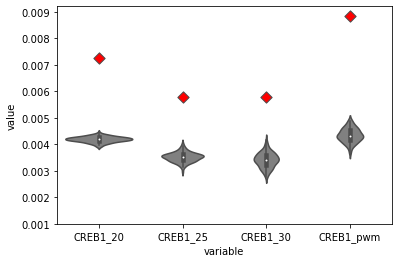

In [35]:
sns.violinplot(data=background_df[background_df['variable'].str.startswith("CREB1")],
               x="variable", y="value",color="grey")
sns.stripplot(data=mutation_df[mutation_df['variable'].str.startswith("CREB1")],
              x="variable",
              y="value", color='red', size=8, jitter=False, linewidth=1, marker='D')
plt.legend([],[], frameon=False)
plt.ylim([.001, .0092])
plt.savefig(fname=f"{OUTPUT_DIR}/Supplementary_Figure_7D_CREB1_Called_Sites.svg", format='svg')

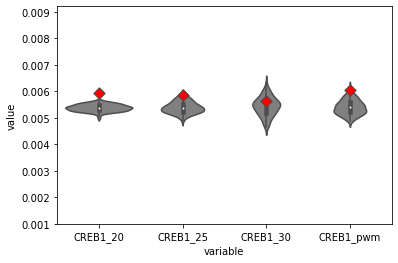

In [36]:
sns.violinplot(data=background_df_shuffle[background_df_shuffle['variable'].str.startswith("CREB1")],
               x="variable", y="value",color="grey")
sns.stripplot(data=mutation_df_shuffle[mutation_df_shuffle['variable'].str.startswith("CREB1")],
              x="variable",
              y="value", color='red', size=8, jitter=False, linewidth=1, marker='D')
plt.legend([],[], frameon=False)
plt.ylim([.001, .0092])
plt.savefig(fname=f"{OUTPUT_DIR}/Supplementary_Figure_7D_CREB1_Shuffle.svg", format='svg')

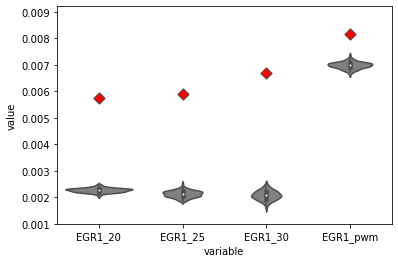

In [37]:
sns.violinplot(data=background_df[background_df['variable'].str.startswith("EGR1")],
               x="variable", y="value",color="grey")
sns.stripplot(data=mutation_df[mutation_df['variable'].str.startswith("EGR1")],
              x="variable",
              y="value", color='red', size=8, jitter=False, linewidth=1, marker='D')
plt.legend([],[], frameon=False)
plt.ylim([.001, .0092])
plt.savefig(fname=f"{OUTPUT_DIR}/Supplementary_Figure_7D_EGR1_Called_Sites.svg", format='svg')

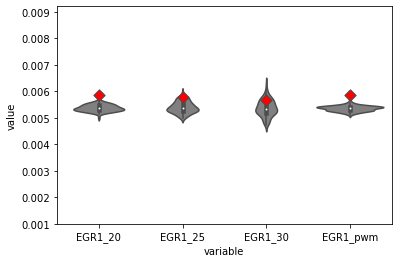

In [38]:
sns.violinplot(data=background_df_shuffle[background_df_shuffle['variable'].str.startswith("EGR1")],
               x="variable", y="value",color="grey")
sns.stripplot(data=mutation_df_shuffle[mutation_df_shuffle['variable'].str.startswith("EGR1")],
              x="variable",
              y="value", color='red', size=8, jitter=False, linewidth=1, marker='D')
plt.legend([],[], frameon=False)
plt.ylim([.001, .0092])
plt.savefig(fname=f"{OUTPUT_DIR}/Supplementary_Figure_7D_EGR1_Shuffle.svg", format='svg')